In [1]:
import numpy as np
from torchvision import datasets
from sklearn import linear_model
from utils import *
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
from base import BaseObjective
from modules import *
from PIL import Image

# Load the .npy file
testset = np.load('cifar10_test_embeddings.npy')
trainset = np.load('cifar10_train_embeddings.npy')

# Load the CIFAR-10 dataset
cifar10_train = datasets.CIFAR10(root='data', train=True, download=True)
cifar10_test = datasets.CIFAR10(root='data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
cifar10_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
# Define a custom dataset to load the precomputed embeddings
class EmbeddingsDataset(Dataset):
    def __init__(self, embeddings, data):
        self.embeddings = embeddings
        self.labels = data.targets
        self.img= data.data

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.embeddings[idx])
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y
    
    
def fit_model(X, Y, L2_WEIGHT):
    C = 1 / (X.shape[0] * L2_WEIGHT)
    sk_clf = linear_model.LogisticRegression(C=C, tol=1e-8, max_iter=1000, multi_class='multinomial')
    sk_clf = sk_clf.fit(X.numpy(), Y.numpy())

    # recreate model in PyTorch
    fc = nn.Linear(2048, 10, bias=True)
    fc.weight = nn.Parameter(torch.tensor(sk_clf.coef_))
    fc.bias = nn.Parameter(torch.tensor(sk_clf.intercept_))

    pt_clf = nn.Sequential(
        fc,
        nn.Softmax(dim=1)
    )

    pt_clf = pt_clf.to(device=device, dtype=torch.float32)
    return pt_clf

# Define the neural network model
X_train = torch.tensor(trainset)
Y_train = torch.tensor(cifar10_train.targets)

X_test = torch.tensor(testset)
Y_test = torch.tensor(cifar10_test.targets)

# Set up the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
L2_WEIGHT = 1e-4

# Load the data
train_data = EmbeddingsDataset(trainset, cifar10_train)
test_data = EmbeddingsDataset(testset, cifar10_test)
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

clf = fit_model(X_train, Y_train, L2_WEIGHT)

In [12]:
clf(X_test[1].unsqeeze(0))

AttributeError: 'Tensor' object has no attribute 'unsqeeze'

In [6]:
import torch.nn.functional as F

class BinClassObjective(BaseObjective):

    def train_outputs(self, model, batch):
        return model(batch[0])

    def train_loss_on_outputs(self, outputs, batch):
        return F.cross_entropy(outputs, batch[1])

    def train_regularization(self, params):
        return L2_WEIGHT * torch.square(params.norm())

    def test_loss(self, model, params, batch):
        outputs = model(batch[0])
        return F.cross_entropy(outputs, batch[1])
    
    
module = LiSSAInfluenceModule(
    model=clf,
    objective=BinClassObjective(),
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    damp=0.001,
    repeat= 1,
    depth=1800,
    scale= 10,
)

In [11]:
# influences = module.influences(train_idxs=), test_idxs=[5])

In [10]:
def df_construct(test_idx, train_idxs):
    influences = module.influences(train_idxs=train_idxs, test_idxs=[test_idx])
    similarity=[cosine_similarity(X_test[test_idx].numpy().reshape(1,-1), X_train[i].numpy().reshape(1, -1)).item()
               for i in range(len(X_train))]
    
    data = {'Influence': influences.reshape(-1).tolist(), 'Similarity': similarity, 'Y_train':Y_train.tolist(), 
            'X_train':X_train.numpy().tolist(), 'image':train_data.img.tolist()}
    df = pd.DataFrame(data)
    return df
test_idx = 21
train_idxs = list(range(len(Y_train)))
df = df_construct(test_idx, train_idxs)

In [154]:
df.sort_values('Influence', ascending=False)[-60:]

,Influence,Similarity,Y_train,X_train,image
28433,-0.000617,0.789715,3,"[0.6285067796707153, 0.20415519177913666, 0.46...","[[[20, 24, 33], [12, 15, 24], [13, 16, 25], [1..."
11873,-0.000623,0.612819,2,"[0.5983749032020569, 0.5232477784156799, 0.134...","[[[163, 177, 168], [163, 174, 165], [153, 161,..."
49819,-0.000639,0.761000,3,"[0.5020532608032227, 0.16975003480911255, 0.05...","[[[157, 179, 200], [159, 181, 202], [161, 183,..."
30059,-0.000641,0.778994,3,"[0.9735748171806335, 0.017226116731762886, 0.2...","[[[114, 110, 100], [115, 111, 101], [117, 113,..."
8054,-0.000644,0.820851,3,"[0.4854780435562134, 0.3154457211494446, 0.396...","[[[1, 1, 7], [5, 3, 14], [4, 3, 12], [0, 0, 3]..."
14192,-0.000645,0.634642,2,"[0.3005792796611786, 0.18988455832004547, 0.39...","[[[36, 49, 22], [43, 56, 30], [58, 73, 46], [7..."
31440,-0.000648,0.814291,3,"[0.5109352469444275, 0.0048903245478868484, 0....","[[[201, 168, 69], [206, 175, 77], [193, 164, 7..."
13329,-0.000649,0.784366,3,"[0.34247004985809326, 0.16129468381404877, 0.1...","[[[0, 0, 0], [1, 1, 1], [3, 3, 3], [2, 2, 2], ..."
11202,-0.000650,0.583375,2,"[0.331371009349823, 0.07367803901433945, 0.228...","[[[187, 105, 53], [193, 106, 53], [181, 93, 49..."
23592,-0.000652,0.678568,6,"[0.41207122802734375, 0.31996989250183105, 0.0...","[[[16, 56, 30], [2, 19, 6], [4, 3, 1], [1, 6, ..."


In [157]:
 def draw(test_indx, train_idxs): 
    # ===========
    # Plot image
    # =========
    new_line = '\n'
    fig, axs = plt.subplots(3, 15, figsize=(12, 10))
    axs[0, 0].imshow(Image.fromarray(test_data.img[test_indx]), interpolation='nearest')
    axs[0, 0].axis('off')
    axs[0, 0].text(0.5, -0.1,f' Actual Label:{cifar10_test.classes[test_data.labels[test_indx]]}, Prediction:{cifar10_test.classes[clf(X_test)[test_idx].argmax()]}', size=10, ha="center", transform=axs[0, 0].transAxes)

    for i, j in enumerate(train_idxs.argsort()[-15:]):
        axs[1, i].imshow(Image.fromarray(train_data.img[j]), interpolation='nearest') 
        axs[1, i].axis('off')
        axs[0, i].axis('off')
        axs[1, i].text(0.5, -0.1,cifar10_train.classes[train_data.labels[j]], size=10, ha="center", transform=axs[1, i].transAxes)
    for i, j in enumerate(train_idxs.argsort()[:15]):
        axs[2, i].imshow(Image.fromarray(train_data.img[j]), interpolation='nearest')
        axs[2, i].axis('off')
        axs[2, i].text(0.5, -0.1,cifar10_train.classes[train_data.labels[j]], size=10, ha="center", transform=axs[2, i].transAxes)

    axs[0, 0].set_title('Test Prediction')
    axs[1, 0].set_title('Helpfull Images')
    axs[2, 0].set_title('Harmfull Images')
    plt.show() 

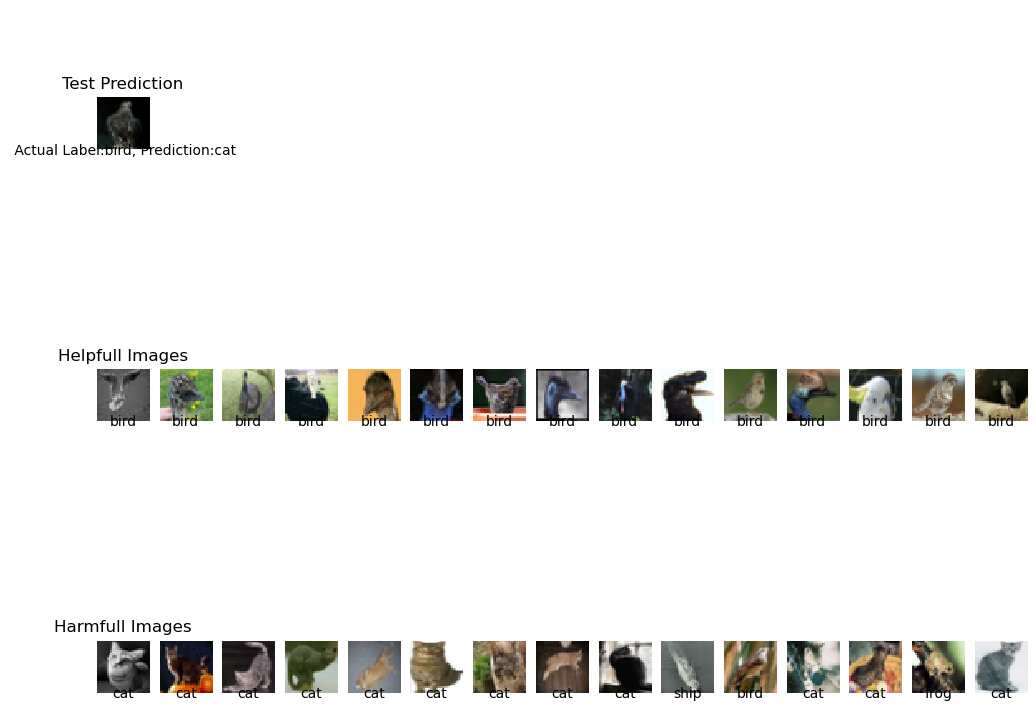

In [158]:
draw(test_idx, np.array(df.Influence.tolist()))

In [85]:
test_losses = F.cross_entropy(clf(X_test.to(device)), Y_test.to(device), reduction="none")
test_idxs = torch.argsort(test_losses, dim=0, descending=True)[:5]
test_idxs = test_idxs.tolist()

In [86]:
test_idxs

[3789, 853, 3531, 7274, 5783]

In [108]:
[i for i in range(len(Y_test)) if cifar10_test.classes[clf(X_test)[i].argmax()]!= cifar10_test.classes[test_data.labels[i]]]

[3,
 20,
 24,
 35,
 37,
 40,
 47,
 50,
 57,
 61,
 63,
 65,
 70,
 74,
 76,
 78,
 81,
 84,
 90,
 95,
 97,
 106,
 116,
 118,
 124,
 128,
 130,
 138,
 139,
 140,
 151,
 158,
 162,
 164,
 169,
 178,
 183,
 184,
 188,
 189,
 195,
 201,
 205,
 218,
 224,
 226,
 229,
 237,
 238,
 251,
 259,
 266,
 275,
 281,
 286,
 302,
 305,
 309,
 313,
 316,
 319,
 323,
 339,
 340,
 342,
 344,
 346,
 354,
 355,
 356,
 363,
 365,
 377,
 378,
 383,
 384,
 385,
 388,
 418,
 422,
 426,
 427,
 428,
 430,
 441,
 448,
 456,
 468,
 470,
 480,
 488,
 505,
 508,
 518,
 525,
 526,
 531,
 532,
 548,
 550,
 556,
 569,
 585,
 600,
 606,
 607,
 611,
 629,
 630,
 631,
 634,
 637,
 639,
 642,
 646,
 655,
 658,
 661,
 665,
 672,
 674,
 675,
 682,
 692,
 703,
 717,
 719,
 725,
 726,
 727,
 728,
 730,
 734,
 735,
 737,
 744,
 751,
 766,
 767,
 775,
 779,
 792,
 793,
 794,
 799,
 810,
 811,
 814,
 820,
 825,
 835,
 851,
 853,
 862,
 863,
 866,
 867,
 875,
 877,
 882,
 888,
 889,
 893,
 897,
 900,
 907,
 910,
 924,
 926,
 932,
 9

In [113]:
(cifar10_test.classes[clf(X_test)[3753].argmax()], cifar10_test.classes[test_data.labels[118]])

('cat', 'bird')

In [123]:
from utils import *

In [124]:
df_pos_sl, df_pos_ol = input_data(df, test_idx, Y_test, sett='positive')
df_neg_ol, df_neg_sl = input_data(df, test_idx, Y_test, sett='negative')
selected_indices_pos_sl = greedy_subset_selection(df_pos_sl, N=5, sett='positive', label='same')
selected_indices_pos_ol = greedy_subset_selection(df_pos_ol, N=5, sett='positive', label='opposite')
selected_indices_neg_sl = greedy_subset_selection(df_neg_sl, N=5, sett='negative', label='same')
selected_indices_neg_ol = greedy_subset_selection(df_neg_ol, N=5, sett='negative', label='opposite')

In [152]:
def print_result(test_idx, selected_indices_neg_ol=None, selected_indices_neg_sl=None,
                 selected_indices_pos_sl=None, selected_indices_pos_ol=None,
                 df_neg_ol=None, df_neg_sl=None,
                 df_pos_sl=None, df_pos_ol=None, intent = None): 

    new_line = '\n'
    fig, axs = plt.subplots(5, 5, figsize=(12, 14))
    axs[0, 0].imshow(Image.fromarray(test_data.img[test_idx]), interpolation='nearest')
    axs[0, 0].axis('off')
    axs[0, 0].text(0.5, -0.1,f'label:{cifar10_test.classes[test_data.labels[test_idx]]} prediction:{cifar10_test.classes[clf(X_test)[test_idx].argmax()]}', size=10, ha="center", transform=axs[0, 0].transAxes)
    axs[0, 0].set_title('Test Prediction')
    if intent=='interpret': 
        axs[1, 1].set_title('Explain by Relevance')
        axs[2, 1].set_title('Explain by Contrast')
    elif intent == 'investigate':
        axs[1, 1].set_title('Ambiguous supporters')
        axs[3, 1].set_title('Good minority')  
    elif intent=='clarify':
        axs[1, 1].set_title('Opposing samples')
        axs[3, 1].set_title('Supporting samples')
    
    
    for i, j in enumerate(selected_indices_pos_sl):
        axs[1, i].imshow(Image.fromarray(train_data.img[df_pos_sl.Influence.index[j]]), interpolation='nearest')
        axs[1, i].axis('off')
        axs[0, i].axis('off')
        axs[1, i].text(0.5, -0.1, cifar10_test.classes[df_pos_sl.Y_train.tolist()[j]], size=10, ha="center", transform=axs[1, i].transAxes)
    
    for i, j in enumerate(selected_indices_pos_ol):
        
        axs[2, i].imshow(Image.fromarray(train_data.img[df_pos_ol.Influence.index[j]]), interpolation='nearest')
        axs[2, i].axis('off')
        axs[2, i].text(0.5, -0.1, cifar10_test.classes[df_pos_ol.Y_train.tolist()[j]], size=10, ha="center", transform=axs[2, i].transAxes)
    
    for i, j in enumerate(selected_indices_neg_ol):
        
        axs[3, i].imshow(Image.fromarray(train_data.img[df_neg_ol.Influence.index[j]]), interpolation='nearest') 
        axs[3, i].axis('off')
        axs[3, i].text(0.5, -0.1, cifar10_test.classes[df_neg_ol.Y_train.tolist()[j]], size=10, ha="center", transform=axs[3, i].transAxes)
    
    for i, j in enumerate(selected_indices_neg_sl):
        axs[4, i].imshow(Image.fromarray(train_data.img[df_neg_sl.Influence.index[j]]), interpolation='nearest') 
        axs[4, i].axis('off')
        axs[4, i].text(0.5, -0.1, cifar10_test.classes[df_neg_sl.Y_train.tolist()[j]], size=10, ha="center", transform=axs[4, i].transAxes)
    
    
    

    plt.show() 

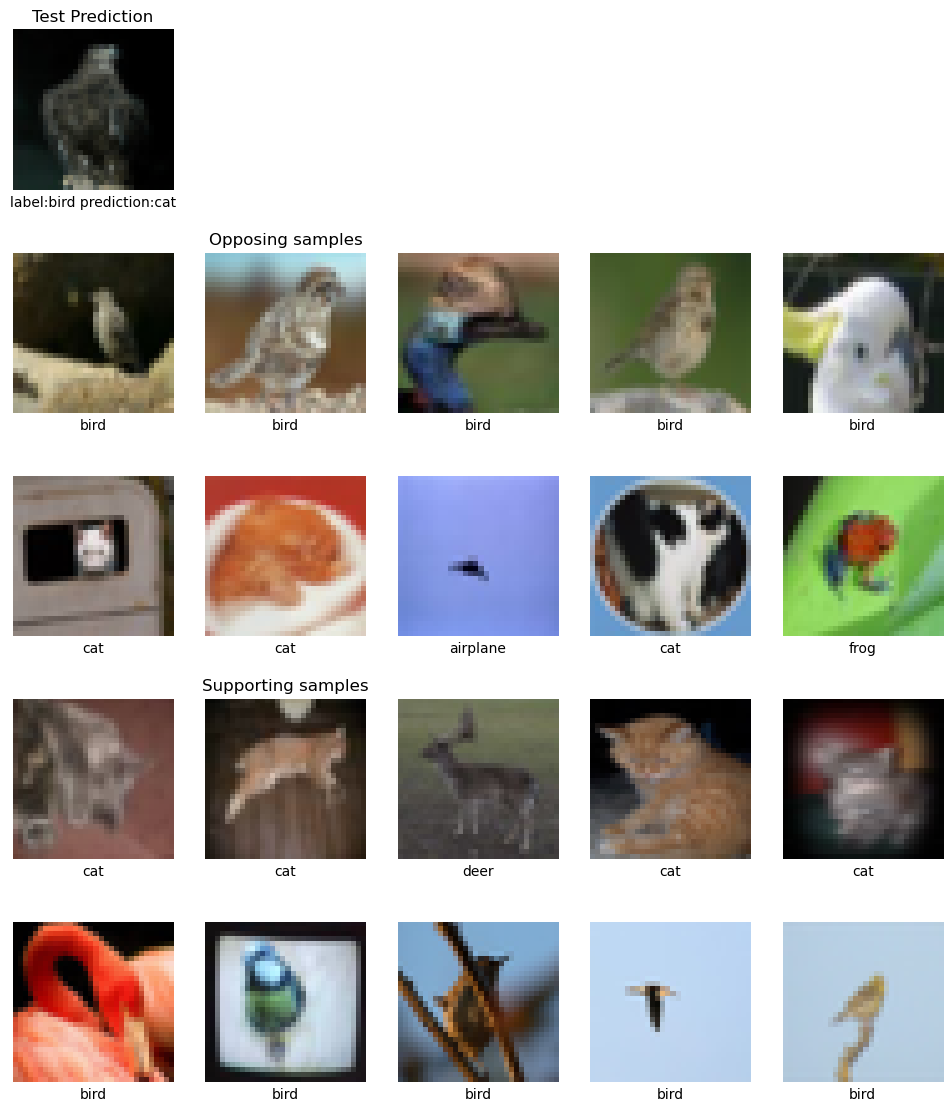

In [153]:
print_result(test_idx, selected_indices_neg_ol=selected_indices_neg_ol, selected_indices_neg_sl=selected_indices_neg_sl,
                 selected_indices_pos_sl=selected_indices_pos_sl, selected_indices_pos_ol=selected_indices_pos_ol,
                 df_neg_ol=df_neg_ol, df_neg_sl=df_neg_sl,
                 df_pos_sl=df_pos_sl, df_pos_ol=df_pos_ol, intent = 'clarify')